### Data extraction

#### Imports

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

####  Read excel

In [71]:
# Load the Excel file
df = pd.read_excel("Hackathon Database.xlsx")

# Remove empty rows (if any) where the energy-related columns are NaN
df = df.dropna(subset=df.columns[1:15], how='all')  # Drop rows where all energy columns are NaN

# Define the maximum allowable value for the machine readings (e.g., 1000000 as an example threshold)
MAX_VALUE_THRESHOLD = 1e5  # Set this threshold based on your domain knowledge

# Replace extreme values with NaN in the energy-related columns
df[df.columns[1:15]] = df[df.columns[1:15]].map(lambda x: x if x <= MAX_VALUE_THRESHOLD else None)

# Drop rows with any NaN values after replacing extreme values
df = df.dropna(subset=df.columns[1:15], how='any')

#### Plot energy for each machine

   Rolling_Avg_Consumption
1                56.118929
2                57.101607
3                57.723071
4                57.256518
5                57.319871


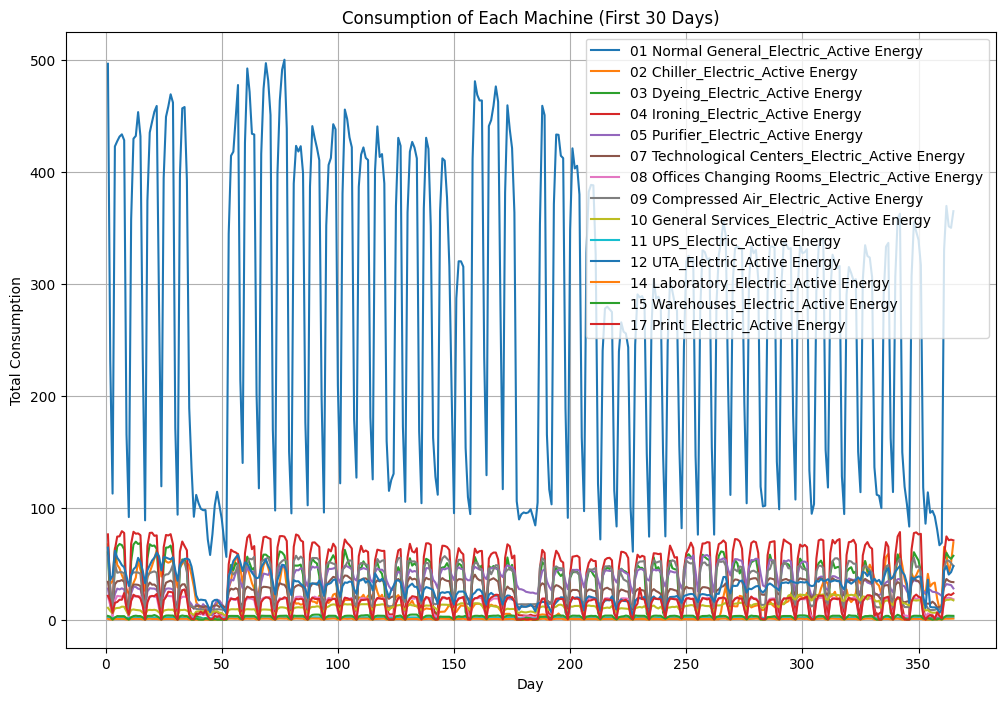

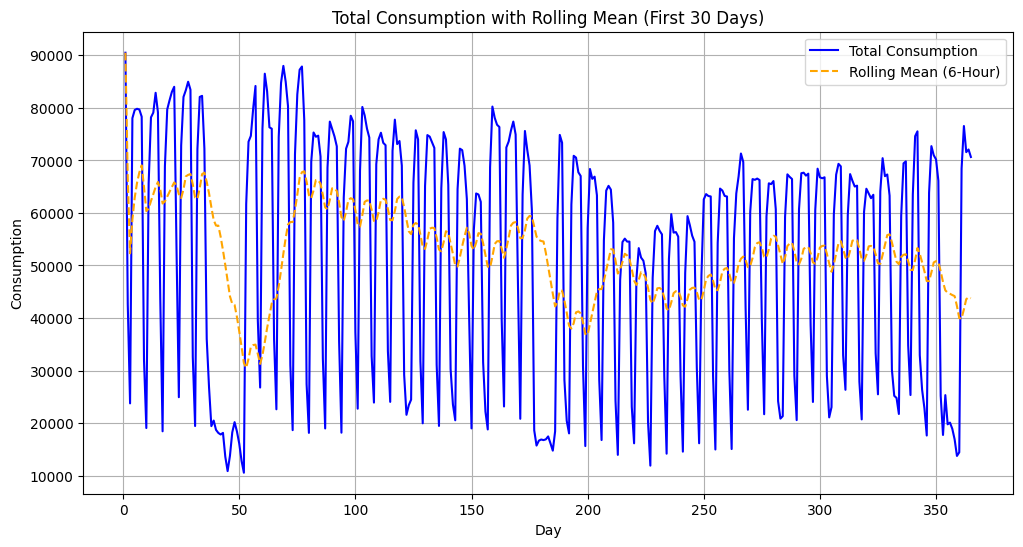

In [57]:
# Define the daily chunk size (excluding the first row which might be headers)
rows_per_day = 96

# Extract the relevant columns
energy_columns = df.loc[:, df.columns[1:15]]  # Columns B to O
power_factor_columns = df.loc[:, df.columns[19:33]]  # Columns T to AG
active_power_columns = df.loc[:, df.columns[36:50]]  # Columns AJ to AW

# Split the dataset into daily chunks and ensure each chunk is a copy
days = [df.iloc[i:i+rows_per_day].copy() for i in range(1, len(df), rows_per_day)] 

# Compute rolling average consumption with a 6-hour window (24 rows, since 15 min per row)
rolling_window = 24
for day in days:
    day['Rolling_Avg_Consumption'] = day.loc[:, df.columns[1:15]].mean(axis=1).rolling(window=rolling_window, min_periods=1).mean()

# Example: Display the first day's data and rolling average
first_day = days[0]
print(first_day[['Rolling_Avg_Consumption']].head())

#--------------------------------------------------------------------------------------------

# Graph the consumption for the first 30 days (for each machine)
plt.figure(figsize=(12, 8))

# Plot each machine's consumption for the first 30 days
for i, col in enumerate(df.columns[1:15]):  # Columns B to O (first 15 columns)
    consumption_data = [(day.loc[:, col].sum() / len(day.loc[:, col])) for day in days[:365]]  # Total daily consumption for each machine
    plt.plot(range(1, 366), consumption_data, label=col)  # Plot for each machine

plt.title('Consumption of Each Machine (First 30 Days)')
plt.xlabel('Day')
plt.ylabel('Total Consumption')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Now plot the total consumption with the rolling mean (for the first 30 days)
total_consumption = [sum(day.loc[:, df.columns[1:15]].sum(axis=1)) for day in days[:365]]  # Sum of all machines per day
rolling_mean = pd.Series(total_consumption).rolling(window=rolling_window, min_periods=1).mean()

# Plot the total consumption and rolling mean
plt.figure(figsize=(12, 6))
plt.plot(range(1, 366), total_consumption, label='Total Consumption', color='blue')
plt.plot(range(1, 366), rolling_mean, label='Rolling Mean (6-Hour)', color='orange', linestyle='--')

plt.title('Total Consumption with Rolling Mean (First 30 Days)')
plt.xlabel('Day')
plt.ylabel('Consumption')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

#### Values of miscellaneous variables

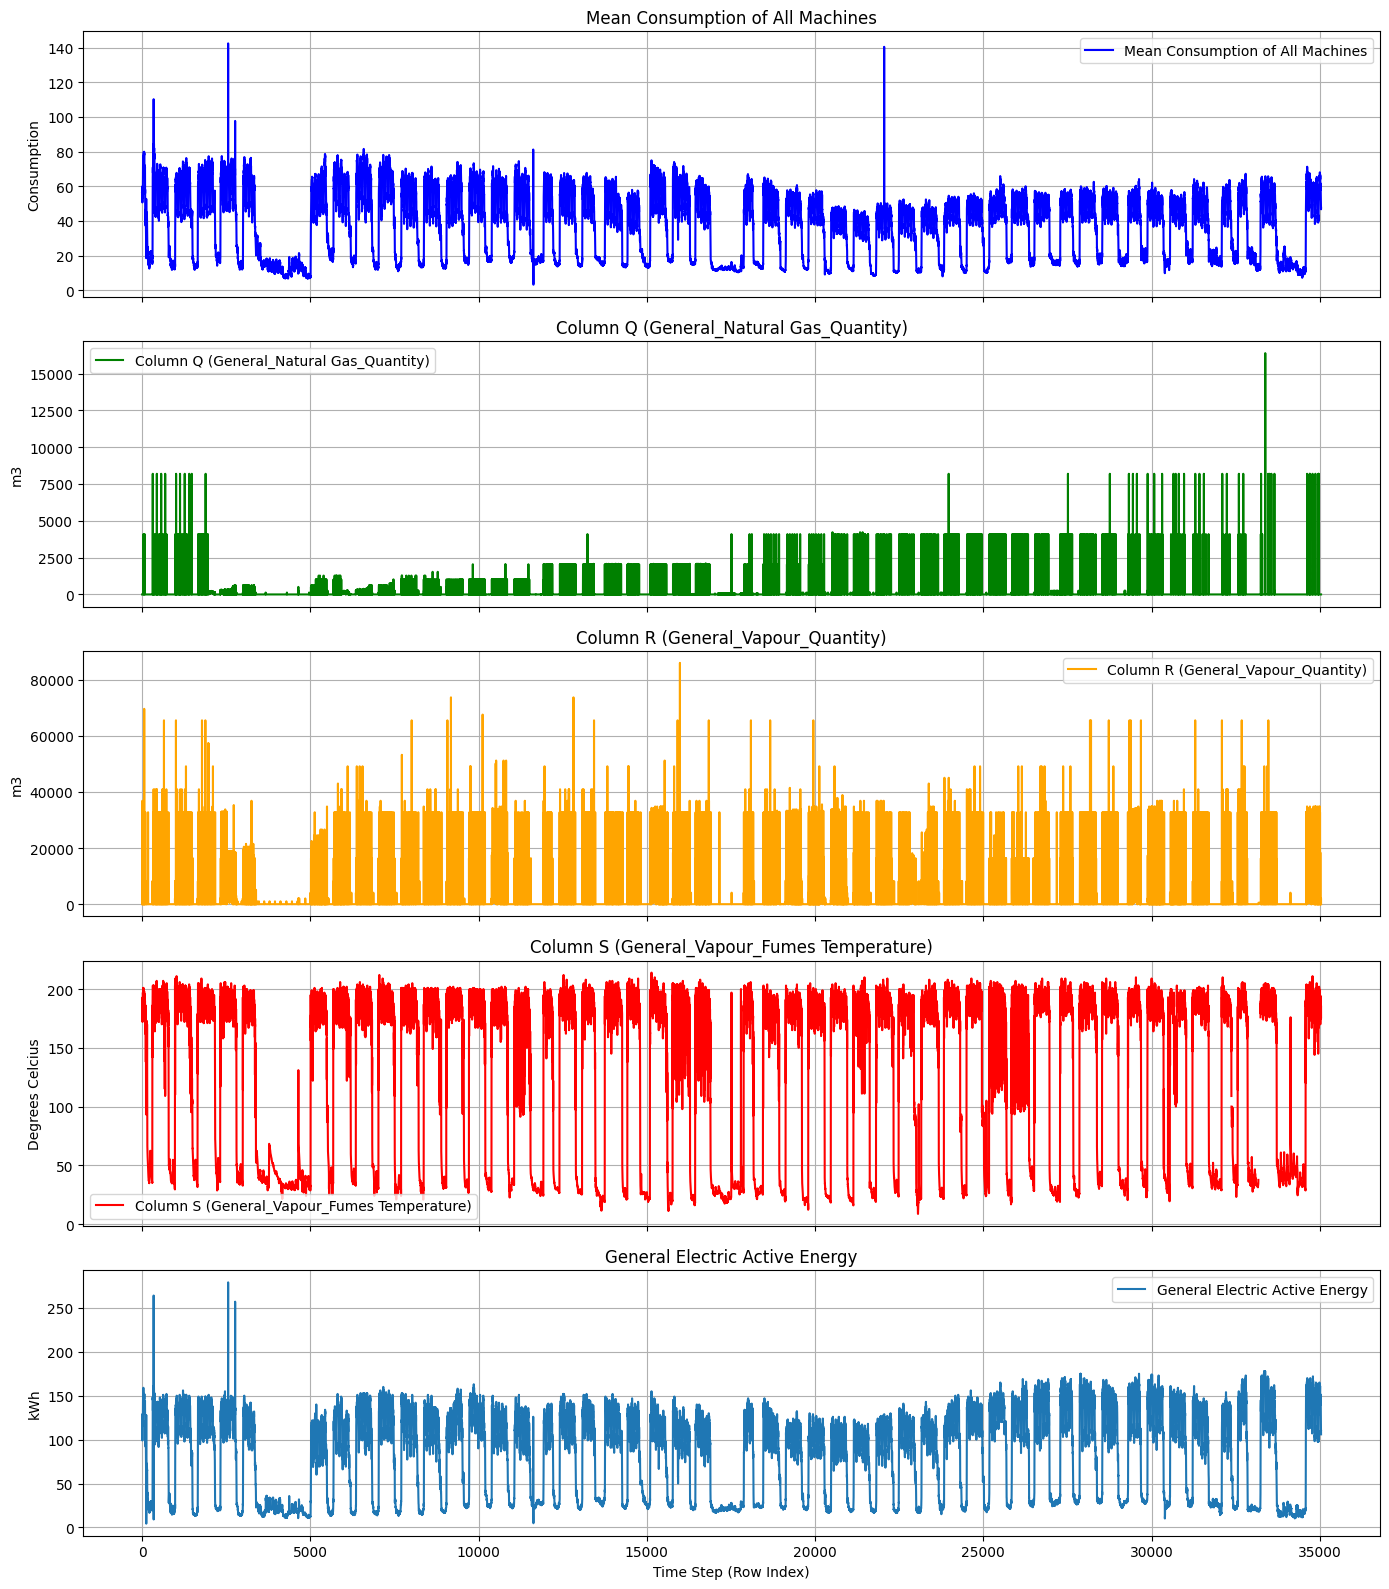

In [ ]:
# Calculate the mean value of all measurements (energy-related columns) for each time step (row)
df['Mean_Consumption'] = df.loc[1:, df.columns[1:15]].mean(axis=1)

# Create a figure with 4 subplots arranged vertically (1 column, 4 rows)
fig, axs = plt.subplots(5, 1, figsize=(14, 16), sharex=True)

# Plot Mean Consumption (for all machines) in the first subplot
axs[0].plot(df.index[1:], df['Mean_Consumption'][1:], label='Mean Consumption of All Machines', color='blue')
axs[0].set_title('Mean Consumption of All Machines')
axs[0].set_ylabel('Consumption')
axs[0].grid(True)
axs[0].legend()

# Plot Column Q (Power Factor) in the second subplot
axs[1].plot(df.index[1:], df.iloc[1:, 16], label='Column Q (General_Natural Gas_Quantity)', color='green')
axs[1].set_title('Column Q (General_Natural Gas_Quantity)')
axs[1].set_ylabel('m3')
axs[1].grid(True)
axs[1].legend()

# Plot Column R (Power Factor) in the third subplot
axs[2].plot(df.index[1:], df.iloc[1:, 17], label='Column R (General_Vapour_Quantity)', color='orange')
axs[2].set_title('Column R (General_Vapour_Quantity)')
axs[2].set_ylabel('m3')
axs[2].grid(True)
axs[2].legend()

# Plot Column S (Power Factor) in the fourth subplot
axs[3].plot(df.index[1:], df.iloc[1:, 18], label='Column S (General_Vapour_Fumes Temperature)', color='red')
axs[3].set_title('Column S (General_Vapour_Fumes Temperature)')
axs[3].set_ylabel('Degrees Celcius')
axs[3].grid(True)
axs[3].legend()

axs[4].plot(df.index[1:], df.iloc[1:, 15], label='General Electric Active Energy')
axs[4].set_title('General Electric Active Energy')
axs[4].set_ylabel('kWh')
axs[4].grid(True)
axs[4].legend()

# Set the common xlabel for all subplots
plt.xlabel('Time Step (Row Index)')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

#### Total energy consumption

Total Energy Consumption over 365 days: 4745473.645 kWh


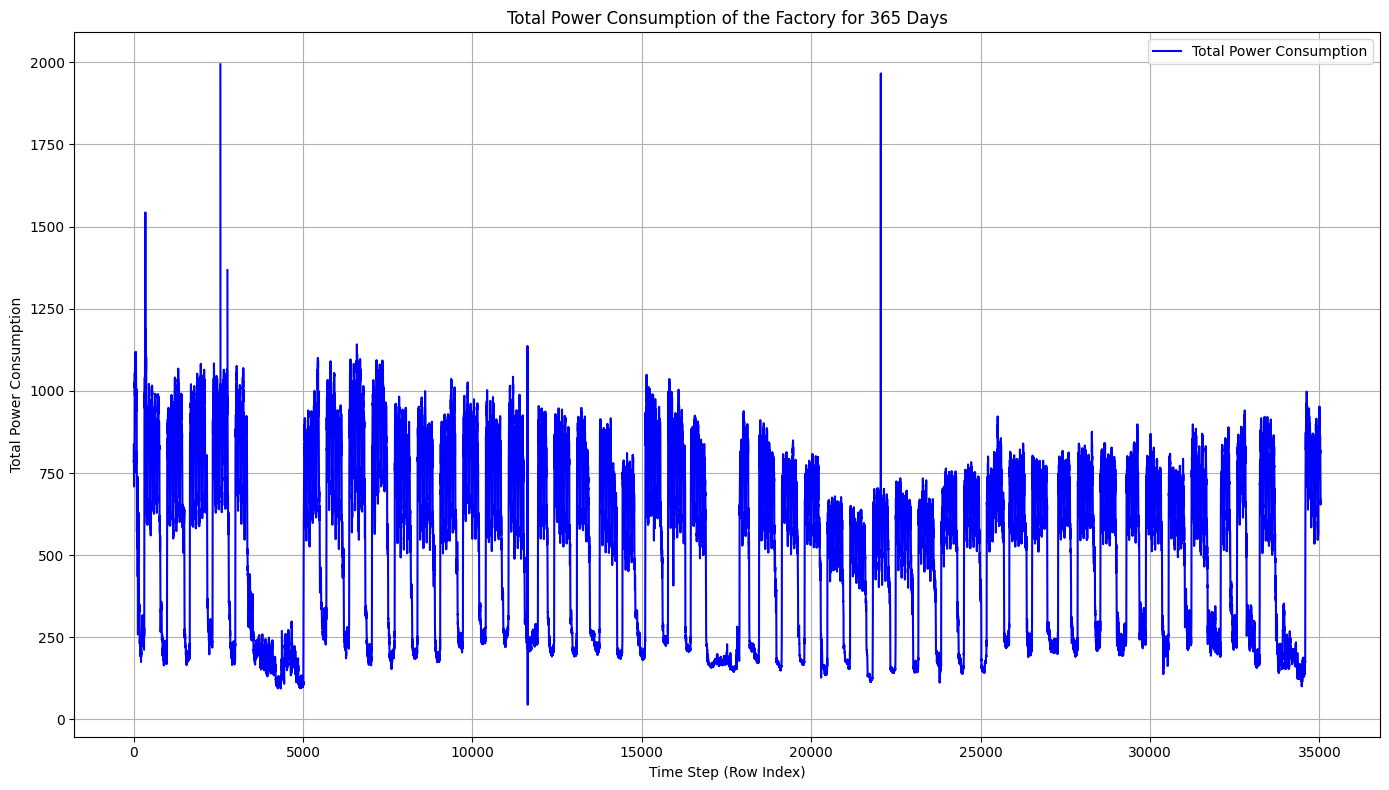

In [62]:
# Calculate the total power consumption (sum of energy values for each time step)
df['Total_Power_Consumption'] = energy_columns.sum(axis=1)

# Multiply total power consumption by the time interval (0.25 hours, since 15 minutes = 0.25 hours)
df['Energy_Consumption'] = df['Total_Power_Consumption'] * 0.25  # Total Energy = Power * Time (0.25 hours)

# Calculate the total energy consumption over the entire period (365 days)
total_energy_consumption = df['Energy_Consumption'].sum()

# Print the total energy consumption
print(f'Total Energy Consumption over 365 days: {total_energy_consumption} kWh')

# Plot the total power consumption for all machines for each time step (15 minutes)
plt.figure(figsize=(14, 8))
plt.plot(df.index[1:], df['Total_Power_Consumption'][1:], label='Total Power Consumption', color='blue', linewidth=1.5)

# Customize the plot
plt.title('Total Power Consumption of the Factory for 365 Days')
plt.xlabel('Time Step (Row Index)')
plt.ylabel('Total Power Consumption')
plt.legend()
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

#### Correlation between data

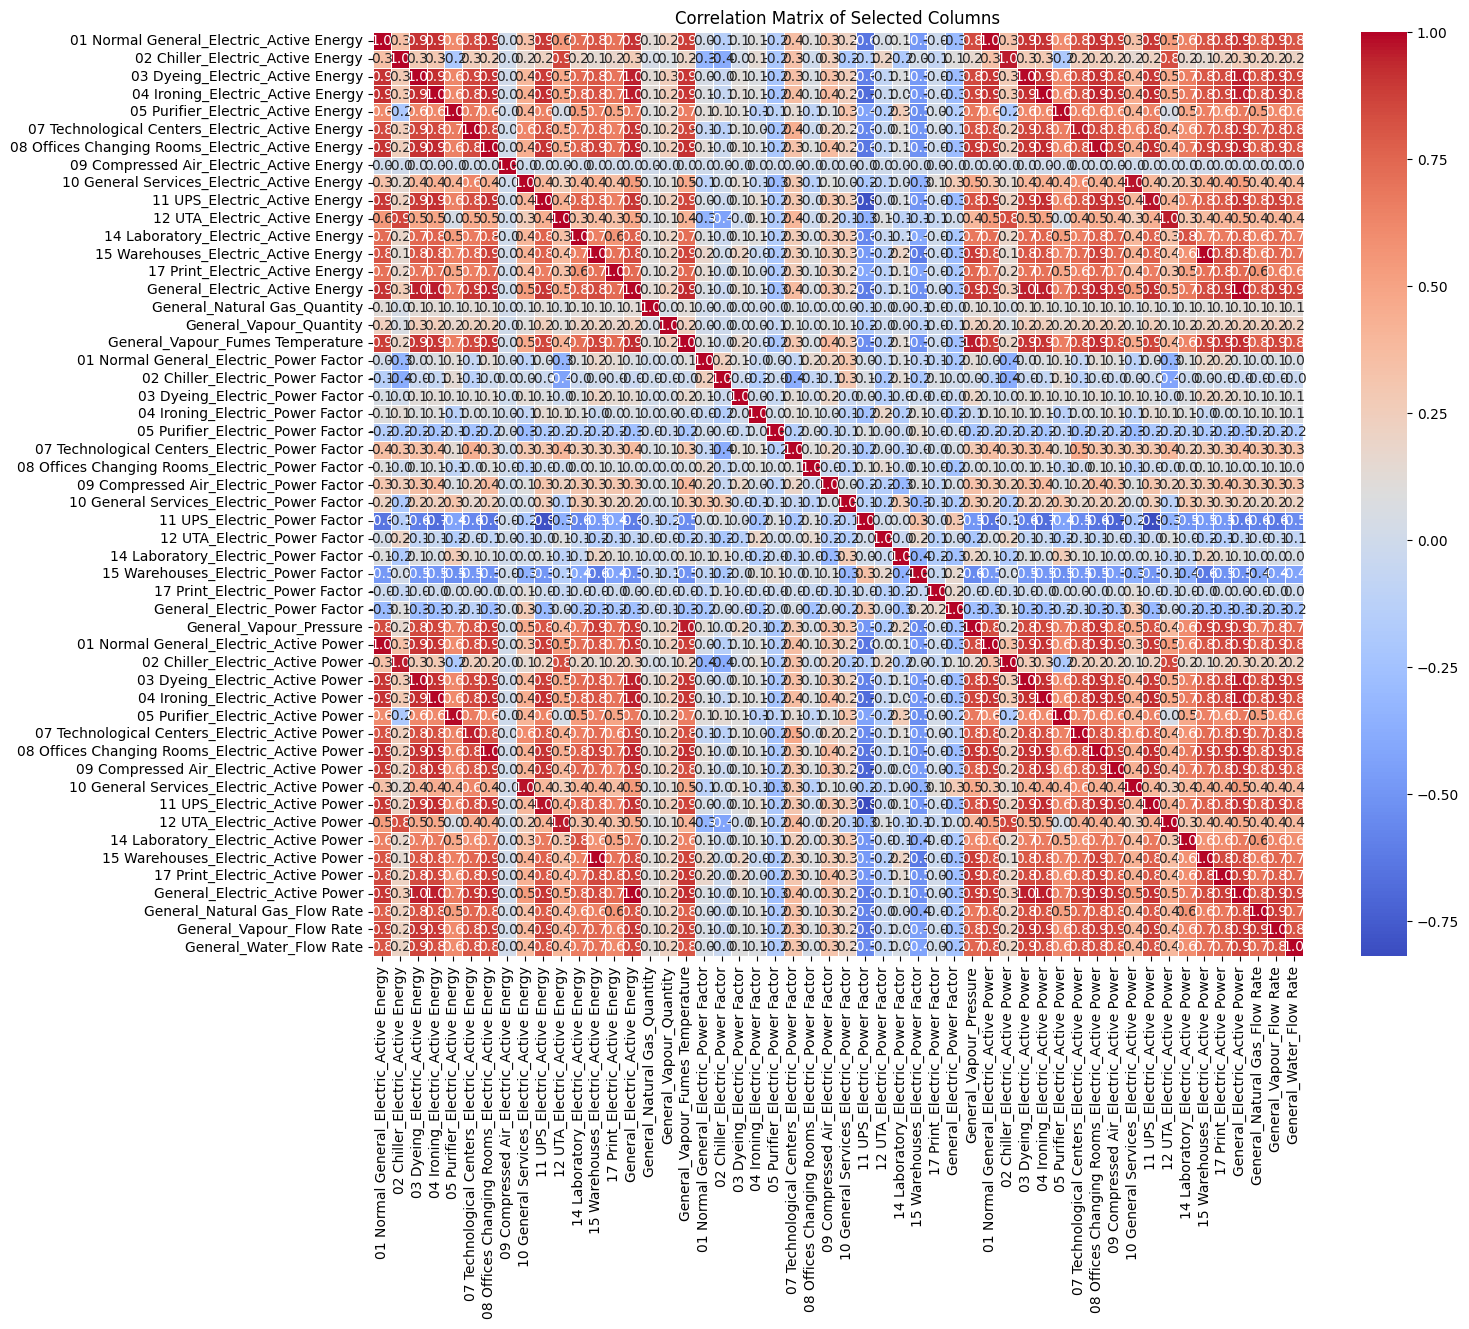

In [66]:
# List of columns to check correlation (you can modify this list if needed)
columns_of_interest = [
    '01 Normal General_Electric_Active Energy',
    '02 Chiller_Electric_Active Energy',
    '03 Dyeing_Electric_Active Energy',
    '04 Ironing_Electric_Active Energy',
    '05 Purifier_Electric_Active Energy',
    '07 Technological Centers_Electric_Active Energy',
    '08 Offices Changing Rooms_Electric_Active Energy',
    '09 Compressed Air_Electric_Active Energy',
    '10 General Services_Electric_Active Energy',
    '11 UPS_Electric_Active Energy',
    '12 UTA_Electric_Active Energy',
    '14 Laboratory_Electric_Active Energy',
    '15 Warehouses_Electric_Active Energy',
    '17 Print_Electric_Active Energy',
    'General_Electric_Active Energy',
    'General_Natural Gas_Quantity',
    'General_Vapour_Quantity',
    'General_Vapour_Fumes Temperature',
    '01 Normal General_Electric_Power Factor',
    '02 Chiller_Electric_Power Factor',
    '03 Dyeing_Electric_Power Factor',
    '04 Ironing_Electric_Power Factor',
    '05 Purifier_Electric_Power Factor',
    '07 Technological Centers_Electric_Power Factor',
    '08 Offices Changing Rooms_Electric_Power Factor',
    '09 Compressed Air_Electric_Power Factor',
    '10 General Services_Electric_Power Factor',
    '11 UPS_Electric_Power Factor',
    '12 UTA_Electric_Power Factor',
    '14 Laboratory_Electric_Power Factor',
    '15 Warehouses_Electric_Power Factor',
    '17 Print_Electric_Power Factor',
    'General_Electric_Power Factor',
    'General_Vapour_Pressure',
    '01 Normal General_Electric_Active Power',
    '02 Chiller_Electric_Active Power',
    '03 Dyeing_Electric_Active Power',
    '04 Ironing_Electric_Active Power',
    '05 Purifier_Electric_Active Power',
    '07 Technological Centers_Electric_Active Power',
    '08 Offices Changing Rooms_Electric_Active Power',
    '09 Compressed Air_Electric_Active Power',
    '10 General Services_Electric_Active Power',
    '11 UPS_Electric_Active Power',
    '12 UTA_Electric_Active Power',
    '14 Laboratory_Electric_Active Power',
    '15 Warehouses_Electric_Active Power',
    '17 Print_Electric_Active Power',
    'General_Electric_Active Power',
    'General_Natural Gas_Flow Rate',
    'General_Vapour_Flow Rate',
    'General_Water_Flow Rate'
]

# Subset the data to include only the selected columns
df_subset = df[columns_of_interest]

# Calculate the correlation matrix
correlation_matrix = df_subset.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.1f', cbar=True, linewidths=0.5)
plt.title('Correlation Matrix of Selected Columns')
plt.show()


Linear Equation: 01 Normal General_Electric_Active Power = 3.99 * 01 Normal General_Electric_Active Energy + 2.17


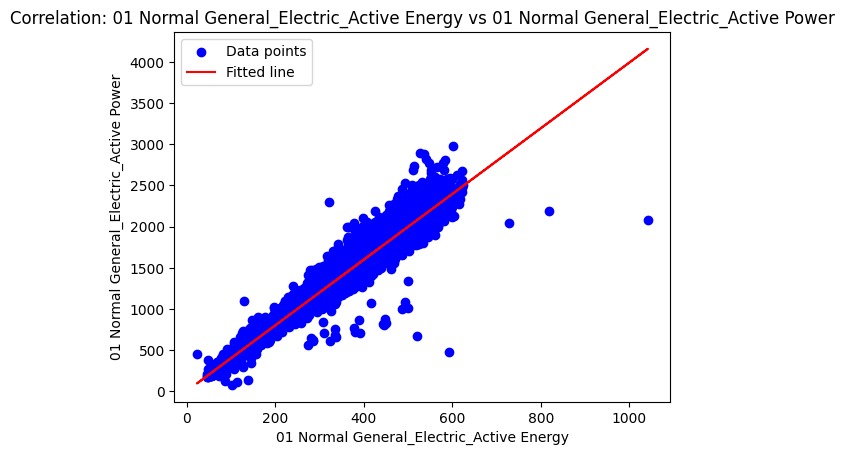

In [72]:
# Choose two columns for correlation (e.g., '01 Normal General_Electric_AE' and '02 Chiller_Electric_AE')
column_1 = '01 Normal General_Electric_Active Energy'
column_2 = '01 Normal General_Electric_Active Power'

# Drop any rows with missing data in these columns
df_clean = df[[column_1, column_2]].dropna()

# Reshape the data to fit into the model (sklearn requires 2D arrays for the features)
X = df_clean[column_1].values.reshape(-1, 1)  # Independent variable
y = df_clean[column_2].values  # Dependent variable

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the coefficients (slope) and intercept
slope = model.coef_[0]
intercept = model.intercept_

# Print the linear equation
print(f"Linear Equation: {column_2} = {slope:.2f} * {column_1} + {intercept:.2f}")

# Plot the data points and the fitted line
plt.scatter(X, y, color='blue', label='Data points')
plt.plot(X, model.predict(X), color='red', label='Fitted line')
plt.xlabel(column_1)
plt.ylabel(column_2)
plt.legend()
plt.title(f"Correlation: {column_1} vs {column_2}")
plt.show()
